In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df=pd.read_csv('../../data/cleaned/cleaned_survey_data.csv')
df.head()

,timestamp,peou_navigation_1,peou_navigation_2,peou_learning_1,peou_learning_2,peou_instructions_1,peou_instructions_2,peou_response_1,peou_response_2,peou_error_1,...,prof_jobless,prof_self_employed___entrepreneur,prof_student,prof_unemployed,education_encoded,opi_purchased?,op_None,fabr_None,gds_None,sos_automobile_None
0,2023-08-02 23:59:11.684,4,4,4,4,4,4,4,3,4,...,0,0,0,0,4,1,0,0,0,0
1,2023-08-03 00:04:13.800,4,3,4,4,3,3,3,3,3,...,0,0,0,0,4,1,0,0,0,0
2,2023-08-03 00:15:31.602,3,4,4,3,4,4,4,3,4,...,0,0,0,0,4,1,0,0,0,0
3,2023-08-03 00:20:49.096,4,3,2,3,3,2,2,2,1,...,0,0,0,0,6,1,0,0,0,0
4,2023-08-03 00:23:52.006,3,4,4,4,4,3,3,4,4,...,0,0,0,0,4,1,0,0,0,0


In [41]:
import warnings
warnings.filterwarnings("ignore")


In [29]:
!pip install missingno


In [32]:
# Count of missing values for each column (top 30 if many)
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]

if not missing.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing.values, y=missing.index, palette='Reds_r')
    plt.title("Missing Values per Column")
    plt.xlabel("Count")
    plt.ylabel("Columns")
    plt.show()
else:
    print("✅ No missing values found.")


✅ No missing values found.


In [36]:
df['peou_score'] = df[[col for col in df.columns if col.startswith('peou_')]].mean(axis=1)
df['pu_score'] = df[[col for col in df.columns if col.startswith('pu_')]].mean(axis=1)
df['attitude_score'] = df[['att_positive_1', 'att_positive_2']].mean(axis=1)
df['risk_score'] = df[['risk_security_1', 'risk_authenticity_1']].mean(axis=1)
df['purchase_intention_score'] = df[['opi_satisfaction', 'opi_behavior_change', 'opi_convenience', 'opi_value']].mean(axis=1)


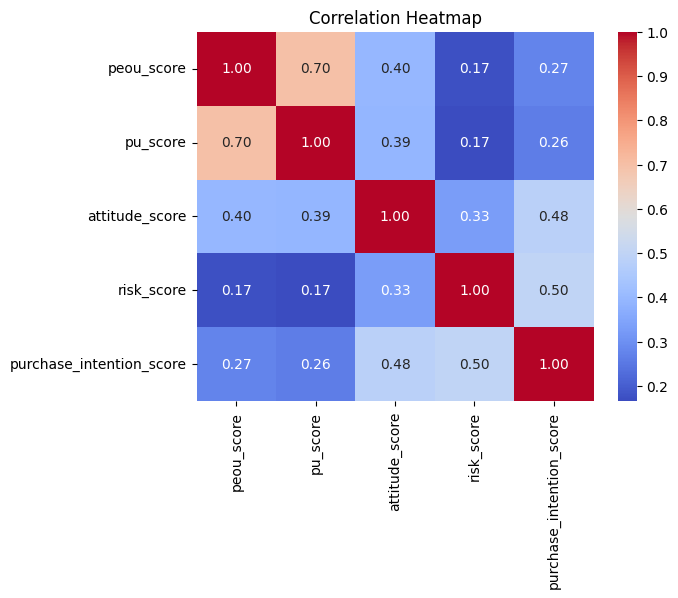

In [37]:
correlation_vars = ['peou_score', 'pu_score', 'attitude_score', 'risk_score', 'purchase_intention_score']
sns.heatmap(df[correlation_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


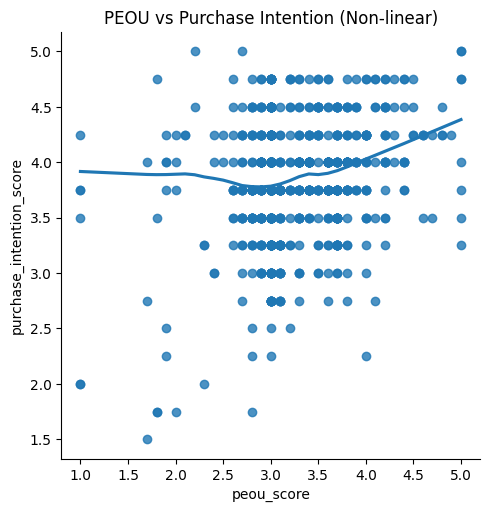

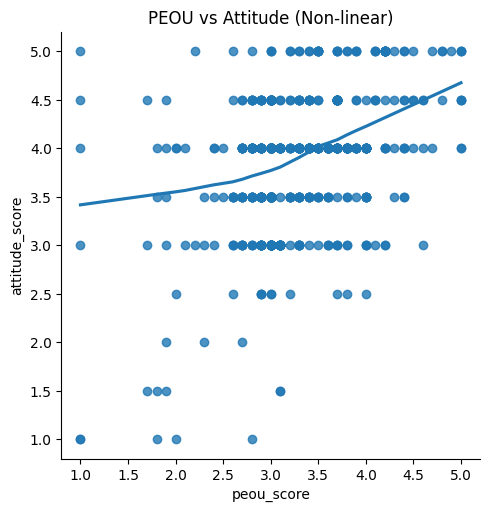

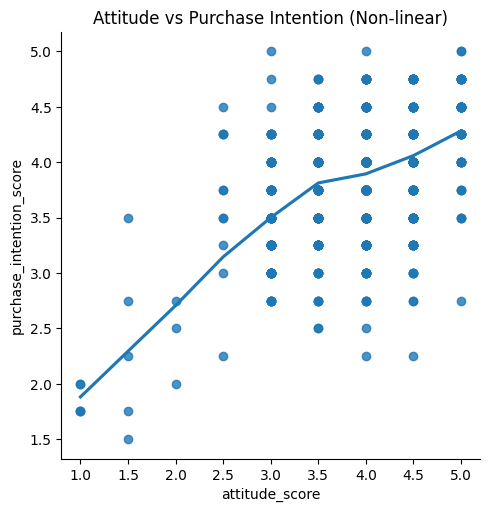

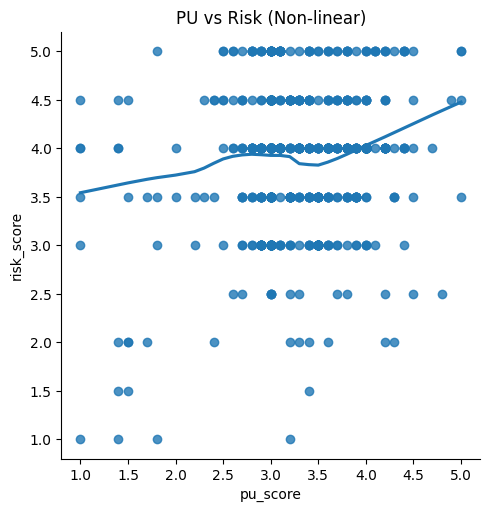

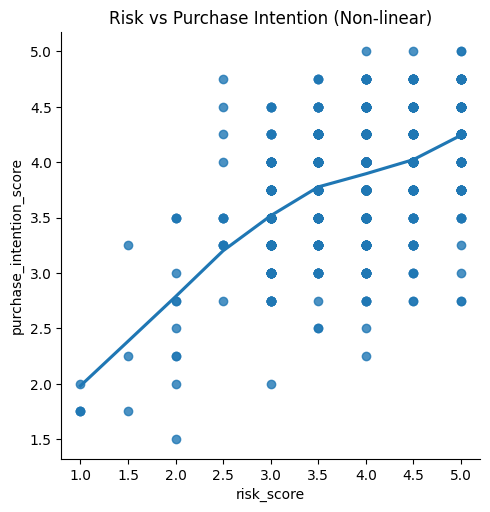

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Composite scores (as shown earlier)
df['peou_score'] = df[[col for col in df.columns if col.startswith('peou_')]].mean(axis=1)
df['pu_score'] = df[[col for col in df.columns if col.startswith('pu_')]].mean(axis=1)
df['attitude_score'] = df[['att_positive_1', 'att_positive_2']].mean(axis=1)
df['risk_score'] = df[['risk_security_1', 'risk_authenticity_1']].mean(axis=1)
df['purchase_intention_score'] = df[['opi_satisfaction', 'opi_behavior_change', 'opi_convenience', 'opi_value']].mean(axis=1)

# Loess-style non-linear plots
sns.lmplot(x='peou_score', y='purchase_intention_score', data=df, lowess=True)
plt.title("PEOU vs Purchase Intention (Non-linear)")
plt.show()

sns.lmplot(x='peou_score', y='attitude_score', data=df, lowess=True)
plt.title("PEOU vs Attitude (Non-linear)")
plt.show()

sns.lmplot(x='attitude_score', y='purchase_intention_score', data=df, lowess=True)
plt.title("Attitude vs Purchase Intention (Non-linear)")
plt.show()

sns.lmplot(x='pu_score', y='risk_score', data=df, lowess=True)
plt.title("PU vs Risk (Non-linear)")
plt.show()

sns.lmplot(x='risk_score', y='purchase_intention_score', data=df, lowess=True)
plt.title("Risk vs Purchase Intention (Non-linear)")
plt.show()


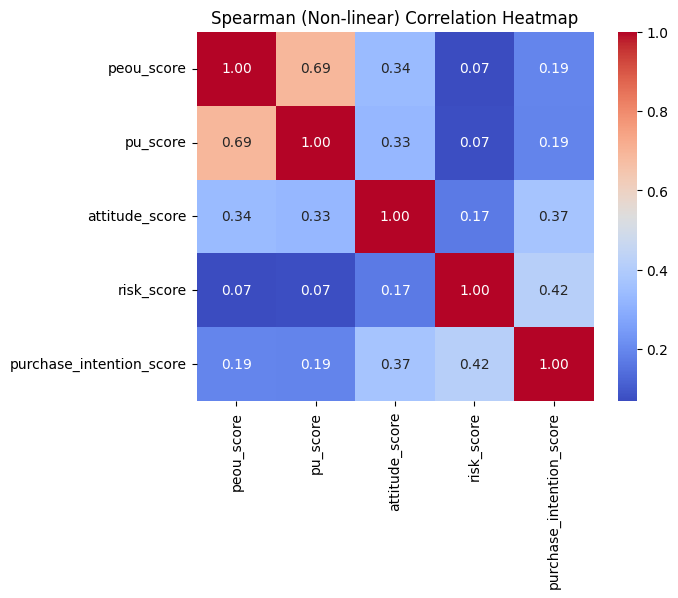

In [43]:
# Spearman correlation matrix (non-parametric)
nonlinear_vars = ['peou_score', 'pu_score', 'attitude_score', 'risk_score', 'purchase_intention_score']
spearman_corr = df[nonlinear_vars].corr(method='spearman')

sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman (Non-linear) Correlation Heatmap")
plt.show()


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
import numpy as np

n_iterations = 5000
indirect_effects = []

for _ in range(n_iterations):
    boot_df = resample(df)

    # a path: PEOU → Attitude
    model_a = RandomForestRegressor().fit(boot_df[['peou_score']], boot_df['attitude_score'])
    a_preds = model_a.predict(boot_df[['peou_score']])
    
    # b path: Attitude → Purchase Intention (controlling for PEOU)
    model_b = RandomForestRegressor().fit(boot_df[['attitude_score', 'peou_score']], boot_df['purchase_intention_score'])
    
    # Predict PI for actual attitude and PEOU
    b_preds = model_b.predict(boot_df[['attitude_score', 'peou_score']])
    
    # Indirect effect approximation: mean effect of a*b
    a_effect = np.mean(a_preds - boot_df['attitude_score'])  # change in attitude due to PEOU
    b_effect = np.mean(b_preds - boot_df['purchase_intention_score'])  # impact of changed attitude
    indirect_effects.append(a_effect * b_effect)

# 95% CI
lower_ci = np.percentile(indirect_effects, 2.5)
upper_ci = np.percentile(indirect_effects, 97.5)
mean_indirect = np.mean(indirect_effects)

print("\nH5: Non-linear Mediation (Bootstrapped using Random Forest)")
print(f"Indirect Effect (mean a*b): {mean_indirect:.4f}")
print(f"95% CI: [{lower_ci:.4f}, {upper_ci:.4f}]")
if lower_ci > 0:
    print("✓ Significant positive mediation.")
elif upper_ci < 0:
    print("✓ Significant negative mediation.")
else:
    print("✗ No significant mediation (CI includes 0).")



H5: Non-linear Mediation (Bootstrapped using Random Forest)
Indirect Effect (mean a*b): 0.0000
95% CI: [-0.0000, 0.0000]
✗ No significant mediation (CI includes 0).


In [48]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 5.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.1 MB 11.5 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 14.9 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 16.5 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 15.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.8 MB 6.4 MB/s eta 0:00:02
   ------------ --------------------------- 3.1/9.8 MB 9.3 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.8 MB 9.9 MB/s eta 0:00:01
   --------------------------- ------------ 6.8/9.8 MB 9.0 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.8 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   -- ------------------------------------- 2.1/41.0 MB 12.0 MB/s eta 0:00:04
   ---- ----------------------------------- 4.5/41.0 MB 11.6 MB/s eta 0:00:04
   ----- ---------------------------------- 6.0/41.0 MB 10.4 MB/s eta 0:00:04
   -------- ------------------------------- 8.4/41.0 MB 10.3 MB/s eta 0:00:04
   ---------- -


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
df.columns

Index(['timestamp', 'peou_navigation_1', 'peou_navigation_2',
       'peou_learning_1', 'peou_learning_2', 'peou_instructions_1',
       'peou_instructions_2', 'peou_response_1', 'peou_response_2',
       'peou_error_1',
       ...
       'prof_unemployed', 'education_encoded', 'opi_purchased?', 'op_None',
       'fabr_None', 'gds_None', 'sos_automobile_None', 'peou_score',
       'attitude_score', 'purchase_intention_score'],
      dtype='object', length=137)

In [18]:
#Bootstrapping

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("\n## Mediation Analysis for Hypothesis 5")

# Create composite scores
peou_cols = ['peou_navigation_1', 'peou_navigation_2',
             'peou_learning_1', 'peou_learning_2',
             'peou_instructions_1', 'peou_instructions_2',
             'peou_response_1', 'peou_response_2',
             'peou_error_1', 'peou_error_2']
df['peou_score'] = df[peou_cols].mean(axis=1)

df['attitude_score'] = df[['att_positive_1', 'att_positive_2']].mean(axis=1)

df['purchase_intention_score'] = df[['opi_satisfaction', 'opi_behavior_change', 'opi_convenience', 'opi_value']].mean(axis=1)

# Step 1: PEOU → Purchase Intention (c path)
model_direct = sm.OLS(df['purchase_intention_score'], sm.add_constant(df['peou_score'])).fit()

# Step 2: PEOU → Attitude (a path)
model_a = sm.OLS(df['attitude_score'], sm.add_constant(df['peou_score'])).fit()

# Step 3: PEOU + Attitude → Purchase Intention (b path and c')
X_mediation = df[['peou_score', 'attitude_score']]
model_mediation = sm.OLS(df['purchase_intention_score'], sm.add_constant(X_mediation)).fit()

# Print coefficients
print("Mediation Results:")
print(f"c path (PEOU → PI): b = {model_direct.params[1]:.4f}, p = {model_direct.pvalues[1]:.4f}")
print(f"a path (PEOU → Attitude): b = {model_a.params[1]:.4f}, p = {model_a.pvalues[1]:.4f}")
print(f"b path (Attitude → PI): b = {model_mediation.params[2]:.4f}, p = {model_mediation.pvalues[2]:.4f}")
print(f"c' path (PEOU → PI, controlling for Attitude): b = {model_mediation.params[1]:.4f}, p = {model_mediation.pvalues[1]:.4f}")

# Indirect effect
indirect_effect = model_a.params[1] * model_mediation.params[2]
total_effect = model_direct.params[1]
prop_mediated = indirect_effect / total_effect if total_effect != 0 else 0

print(f"\nIndirect Effect (a*b): {indirect_effect:.4f}")
print(f"Total Effect (c): {total_effect:.4f}")
print(f"Proportion Mediated: {prop_mediated:.4f} ({prop_mediated * 100:.2f}%)")

# Bootstrap confidence interval for indirect effect
np.random.seed(42)
n_bootstrap = 5000
indirects = []

for _ in range(n_bootstrap):
    idx = np.random.choice(df.index, size=len(df), replace=True)
    sample = df.loc[idx]
    
    a = sm.OLS(sample['attitude_score'], sm.add_constant(sample['peou_score'])).fit().params[1]
    b = sm.OLS(sample['purchase_intention_score'], 
               sm.add_constant(sample[['peou_score', 'attitude_score']])).fit().params[2]
    
    indirects.append(a * b)

ci_lower = np.percentile(indirects, 2.5)
ci_upper = np.percentile(indirects, 97.5)

print(f"\nBootstrap 95% CI for Indirect Effect: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0 and ci_upper > 0:
    print("✓ Indirect effect is statistically significant (positive mediation).")
elif ci_lower < 0 and ci_upper < 0:
    print("✓ Indirect effect is statistically significant and negative.")
else:
    print("✗ Indirect effect is not statistically significant (CI includes zero).")

# Interpretation
print("\nInterpretation:")
if ci_lower > 0 or ci_upper < 0:
    if model_mediation.pvalues[1] < 0.05:
        print("✓ PARTIAL MEDIATION: Attitude partially mediates the effect of PEOU on Purchase Intention.")
    else:
        print("✓ FULL MEDIATION: Attitude fully mediates the effect of PEOU.")
else:
    print("✗ NO MEDIATION: Attitude does not significantly mediate the effect.")



## Mediation Analysis for Hypothesis 5
Mediation Results:
c path (PEOU → PI): b = 0.2536, p = 0.0000
a path (PEOU → Attitude): b = 0.4518, p = 0.0000
b path (Attitude → PI): b = 0.3618, p = 0.0000
c' path (PEOU → PI, controlling for Attitude): b = 0.0901, p = 0.0034

Indirect Effect (a*b): 0.1635
Total Effect (c): 0.2536
Proportion Mediated: 0.6445 (64.45%)

Bootstrap 95% CI for Indirect Effect: [0.1118, 0.2232]
✓ Indirect effect is statistically significant (positive mediation).

Interpretation:
✓ PARTIAL MEDIATION: Attitude partially mediates the effect of PEOU on Purchase Intention.


In [19]:
model1 = sm.OLS(df['purchase_intention_score'], sm.add_constant(df['peou_score'])).fit()
print(model1.summary())


                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.075
Model:                                  OLS   Adj. R-squared:                  0.074
Method:                       Least Squares   F-statistic:                     66.41
Date:                      Mon, 12 May 2025   Prob (F-statistic):           1.36e-15
Time:                              12:36:50   Log-Likelihood:                -597.56
No. Observations:                       825   AIC:                             1199.
Df Residuals:                           823   BIC:                             1209.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [20]:
X = df[['peou_score', 'attitude_score']]
model2 = sm.OLS(df['purchase_intention_score'], sm.add_constant(X)).fit()
print(model2.summary())


                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.241
Model:                                  OLS   Adj. R-squared:                  0.240
Method:                       Least Squares   F-statistic:                     130.8
Date:                      Mon, 12 May 2025   Prob (F-statistic):           4.87e-50
Time:                              12:36:56   Log-Likelihood:                -515.61
No. Observations:                       825   AIC:                             1037.
Df Residuals:                           822   BIC:                             1051.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [21]:
model3 = sm.OLS(df['purchase_intention_score'], sm.add_constant(df['attitude_score'])).fit()
print(model3.summary())


                               OLS Regression Results                               
Dep. Variable:     purchase_intention_score   R-squared:                       0.233
Model:                                  OLS   Adj. R-squared:                  0.233
Method:                       Least Squares   F-statistic:                     250.6
Date:                      Mon, 12 May 2025   Prob (F-statistic):           1.78e-49
Time:                              12:37:03   Log-Likelihood:                -519.92
No. Observations:                       825   AIC:                             1044.
Df Residuals:                           823   BIC:                             1053.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------